In [30]:
import pandas as pd
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging

import seaborn as sns

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True



In [31]:
key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)

# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 131, 127, 130, 143, 144, 145, 146, 128, 147, 129]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'tenant type', 'age', 'building type', 'solar panels', 'heat pump', 'electric vehicle', 'electric water heating', 'monthly income', 'number of residents', 'education level']

#print(extracted_df)

# Save extracted columns to a new Excel or CSV file if needed

#extracted_df.to_csv("extracted_columns.csv", index=False)

In [32]:

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

#print(extracted_df)


In [33]:
result_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/day_avg_clustering.csv")

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]"),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]")
]).sort("cluster")

print(cluster_summary)

shape: (5, 4)
┌─────────┬────────────────┬─────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_total_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                         ┆ ---                         │
│ i64     ┆ u32            ┆ f64                         ┆ f64                         │
╞═════════╪════════════════╪═════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 766            ┆ 2064.352896                 ┆ 3.5353                      │
│ 2       ┆ 64             ┆ 16122.100328                ┆ 26.51256                    │
│ 3       ┆ 123            ┆ 8851.395138                 ┆ 15.914084                   │
│ 4       ┆ 416            ┆ 4666.584517                 ┆ 7.91538                     │
│ 5       ┆ 95             ┆ 8865.541484                 ┆ 14.002136                   │
└─────────┴────────────────┴─────────────────────────────┴─────────────────────────────┘


In [34]:
result_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/day_avg_clustering.csv")

extracted_pl_df = pl.from_pandas(extracted_df)

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

extracted_pl_df = extracted_pl_df.with_columns(
    pl.col("CH_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

# First join: attach survey columns
joined = result_df.join(
    extracted_pl_df.select([
        "ch_id_clean",
        "tenant type",
        "age",
        "building type",
        "solar panels",
        "heat pump",
        "electric vehicle",
        "electric water heating",
        "monthly income",
        "number of residents",
        "education level"
    ]),
    on="ch_id_clean",
    how="left"
)

# Second join: attach consumption
joined = joined.join(
    alle_mittelwerte_df.select(["ch_id_clean", "bruttolastgang_kwh_sum"]),
    on="ch_id_clean",
    how="left"
)

# Now select in the desired order
final_df = joined.select([
    "house_id",                # Column 0
    "bruttolastgang_kwh_sum",  # Column 1
    "cluster",                 # Column 2
    "tenant type",
    "age",
    "building type",
    "solar panels",
    "heat pump",
    "electric vehicle",
    "electric water heating",
    "monthly income",
    "number of residents",
    "education level"
])

print(final_df.head())

shape: (5, 13)
┌────────────┬────────────┬─────────┬────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ house_id   ┆ bruttolast ┆ cluster ┆ tenant ┆ … ┆ electric   ┆ monthly    ┆ number of ┆ education │
│ ---        ┆ gang_kwh_s ┆ ---     ┆ type   ┆   ┆ water      ┆ income     ┆ residents ┆ level     │
│ str        ┆ um         ┆ i64     ┆ ---    ┆   ┆ heating    ┆ ---        ┆ ---       ┆ ---       │
│            ┆ ---        ┆         ┆ str    ┆   ┆ ---        ┆ str        ┆ f64       ┆ str       │
│            ┆ f64        ┆         ┆        ┆   ┆ str        ┆            ┆           ┆           │
╞════════════╪════════════╪═════════╪════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 1726.86    ┆ 1       ┆ Owner  ┆ … ┆ no         ┆ 10000 CHF  ┆ 2.0       ┆ Tertiary  │
│ 3450000000 ┆            ┆         ┆        ┆   ┆            ┆ or more    ┆           ┆ degree    │
│ 0000000047 ┆            ┆         ┆        ┆   ┆            ┆            ┆

In [35]:
def categorize_consumption(value):
    if value < 5000:
        return "0-5 MWh"
    elif value < 10000:
        return "5-10 MWh"
    elif value < 15000:
        return "10-15 MWh"
    elif value < 20000:
        return "15-20 MWh"
    elif value < 25000:
        return "20-25 MWh"
    else:
        return "25+ MWh"

final_df = final_df.with_columns(
    pl.col("bruttolastgang_kwh_sum")
      .map_elements(categorize_consumption, return_dtype=pl.Utf8)
      .alias("consumption_category")
)

print(final_df.head())

shape: (5, 14)
┌────────────┬────────────┬─────────┬────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ house_id   ┆ bruttolast ┆ cluster ┆ tenant ┆ … ┆ monthly    ┆ number of  ┆ education ┆ consumpti │
│ ---        ┆ gang_kwh_s ┆ ---     ┆ type   ┆   ┆ income     ┆ residents  ┆ level     ┆ on_catego │
│ str        ┆ um         ┆ i64     ┆ ---    ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ry        │
│            ┆ ---        ┆         ┆ str    ┆   ┆ str        ┆ f64        ┆ str       ┆ ---       │
│            ┆ f64        ┆         ┆        ┆   ┆            ┆            ┆           ┆ str       │
╞════════════╪════════════╪═════════╪════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 1726.86    ┆ 1       ┆ Owner  ┆ … ┆ 10000 CHF  ┆ 2.0        ┆ Tertiary  ┆ 0-5 MWh   │
│ 3450000000 ┆            ┆         ┆        ┆   ┆ or more    ┆            ┆ degree    ┆           │
│ 0000000047 ┆            ┆         ┆        ┆   ┆            ┆            ┆

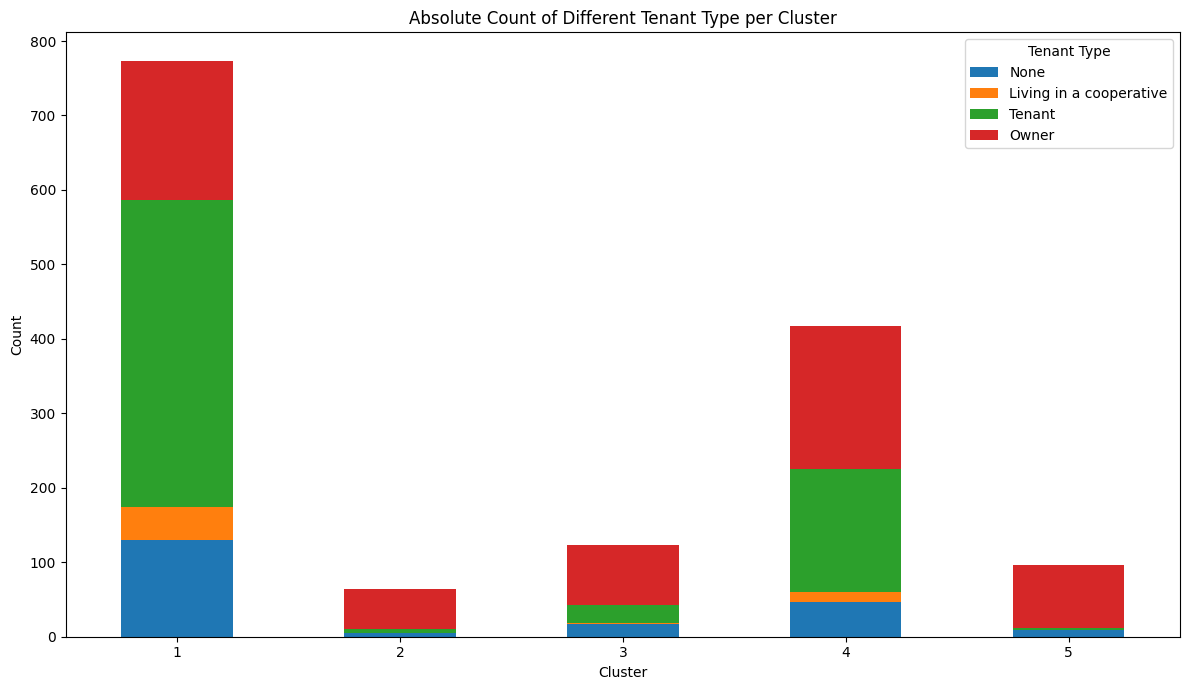

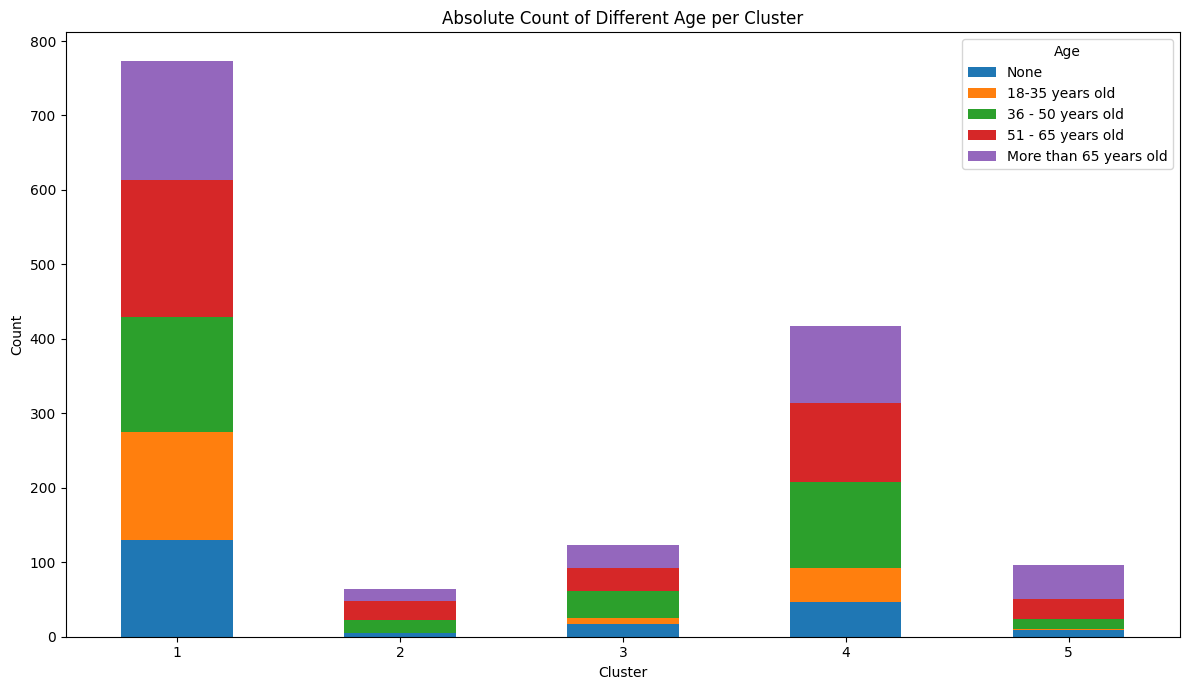

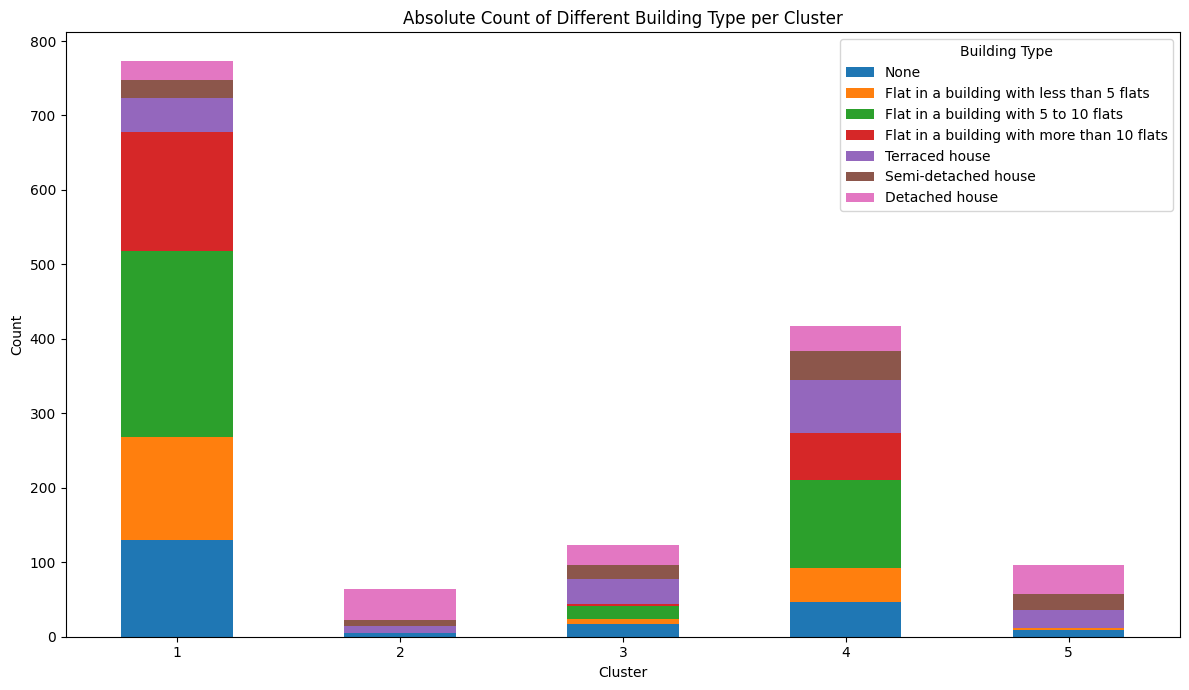

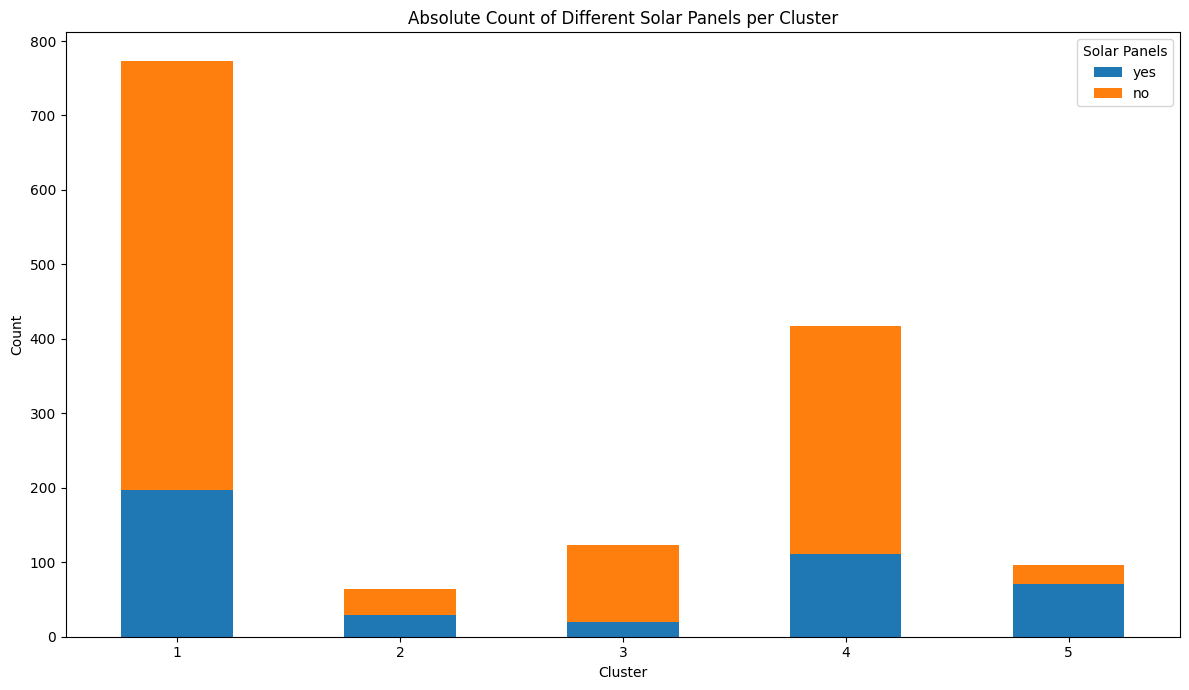

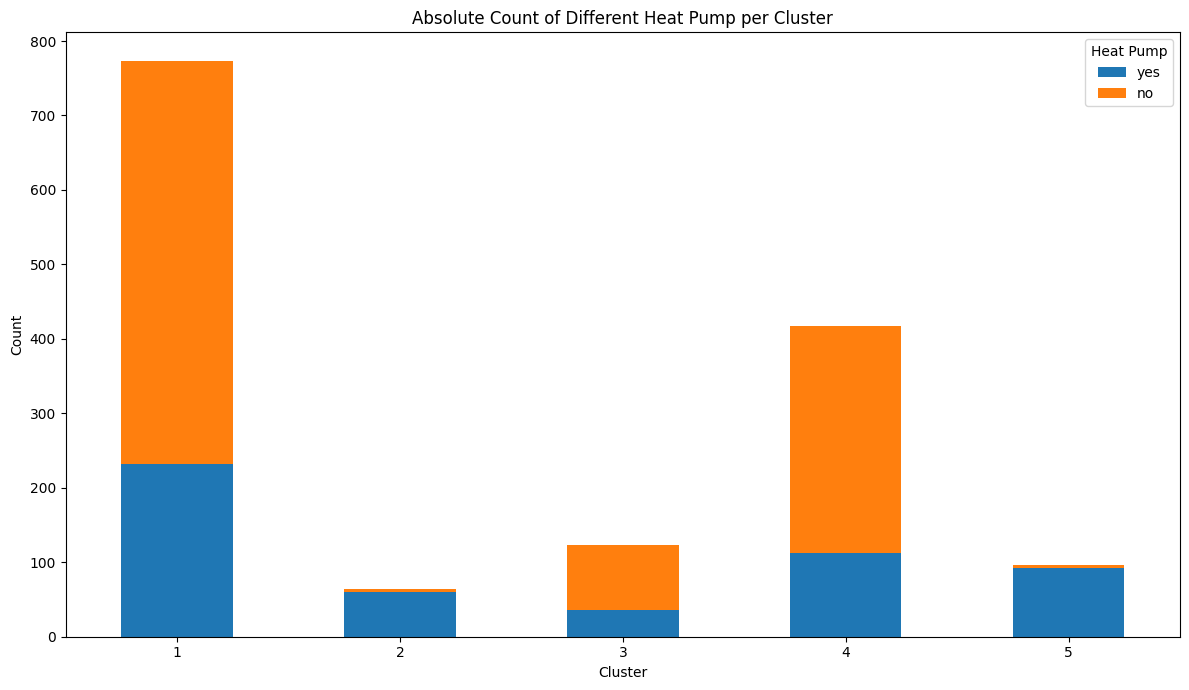

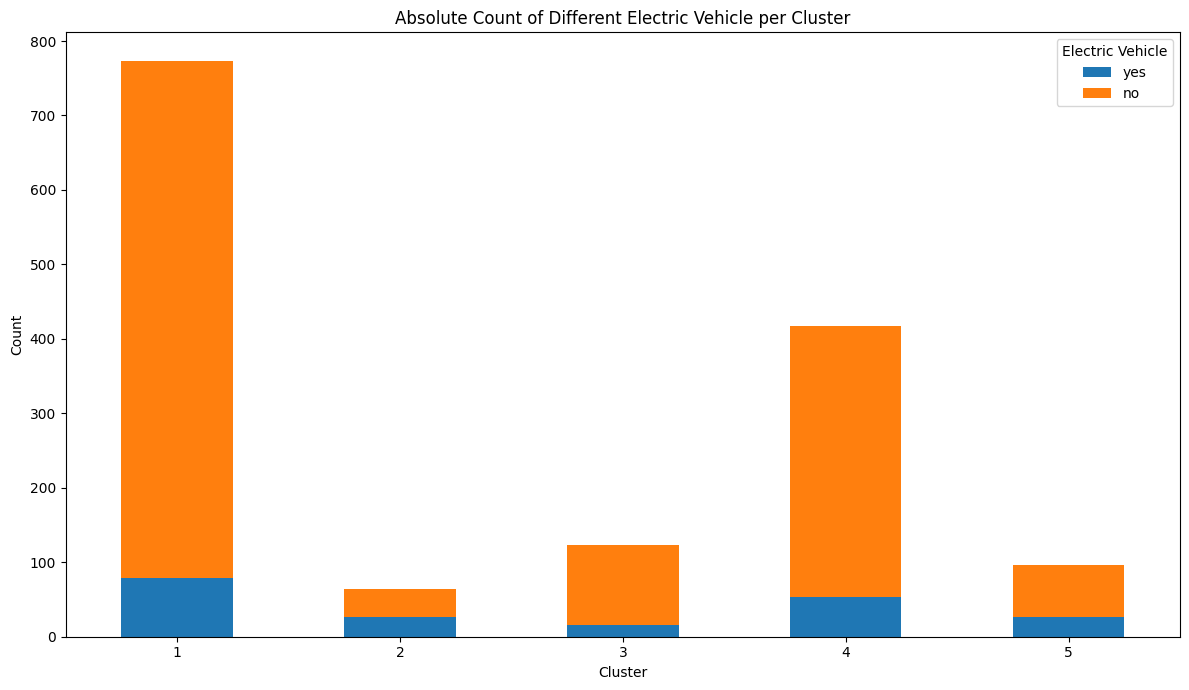

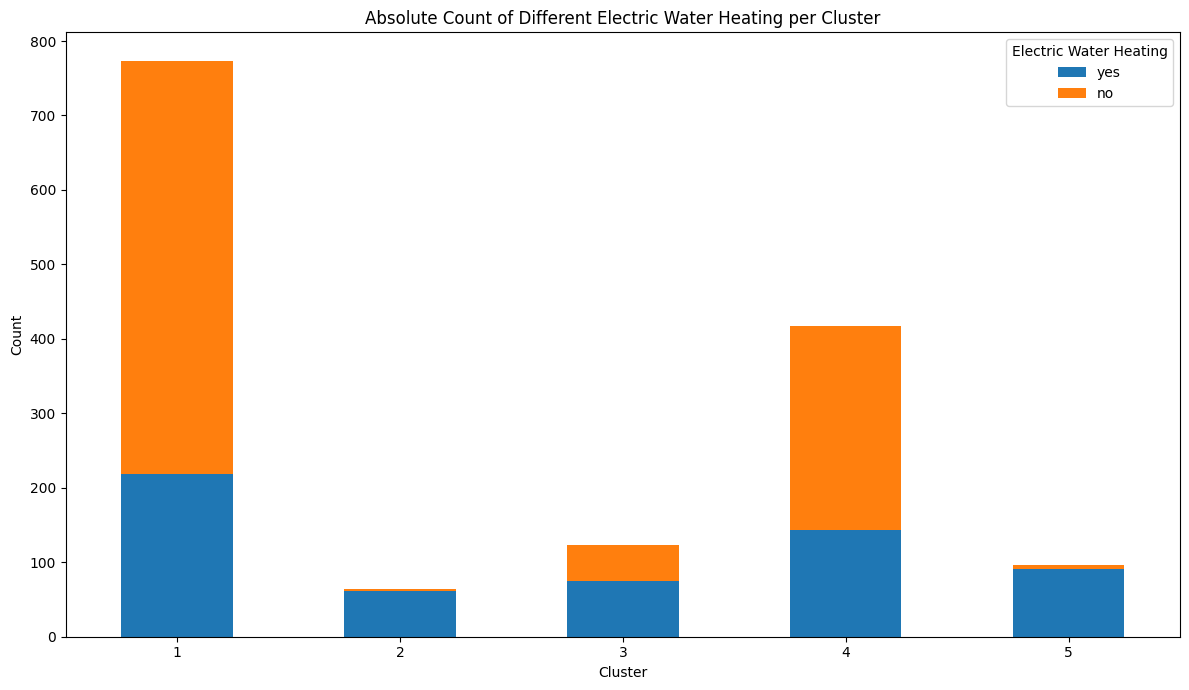

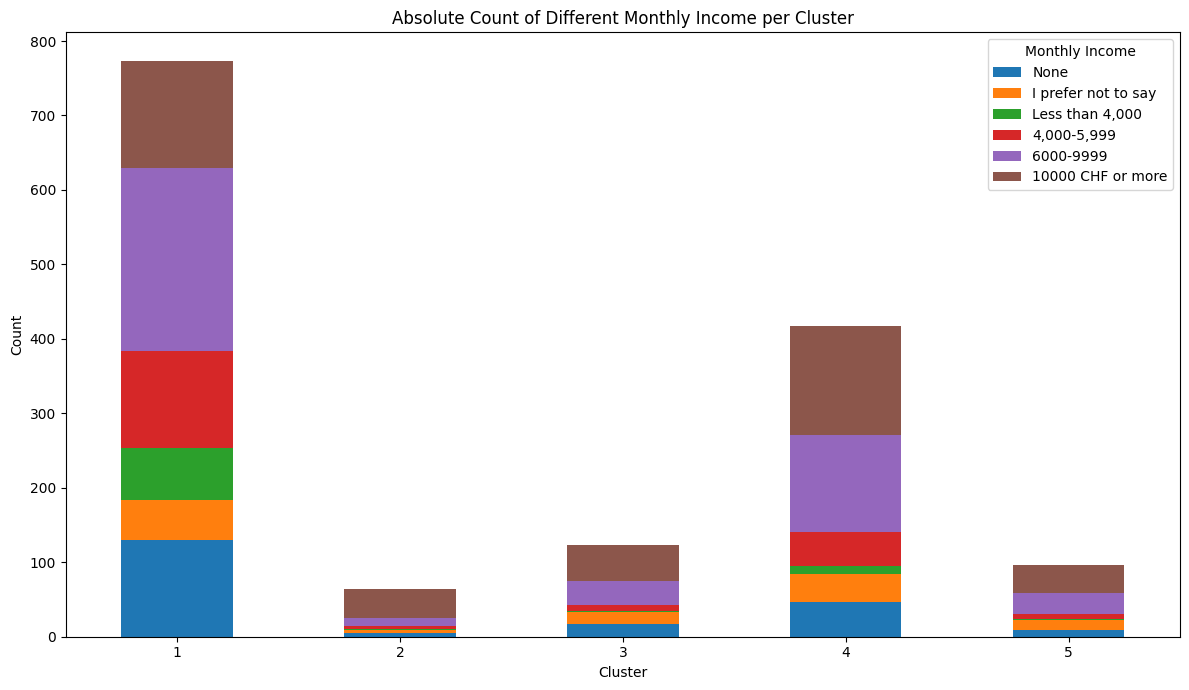

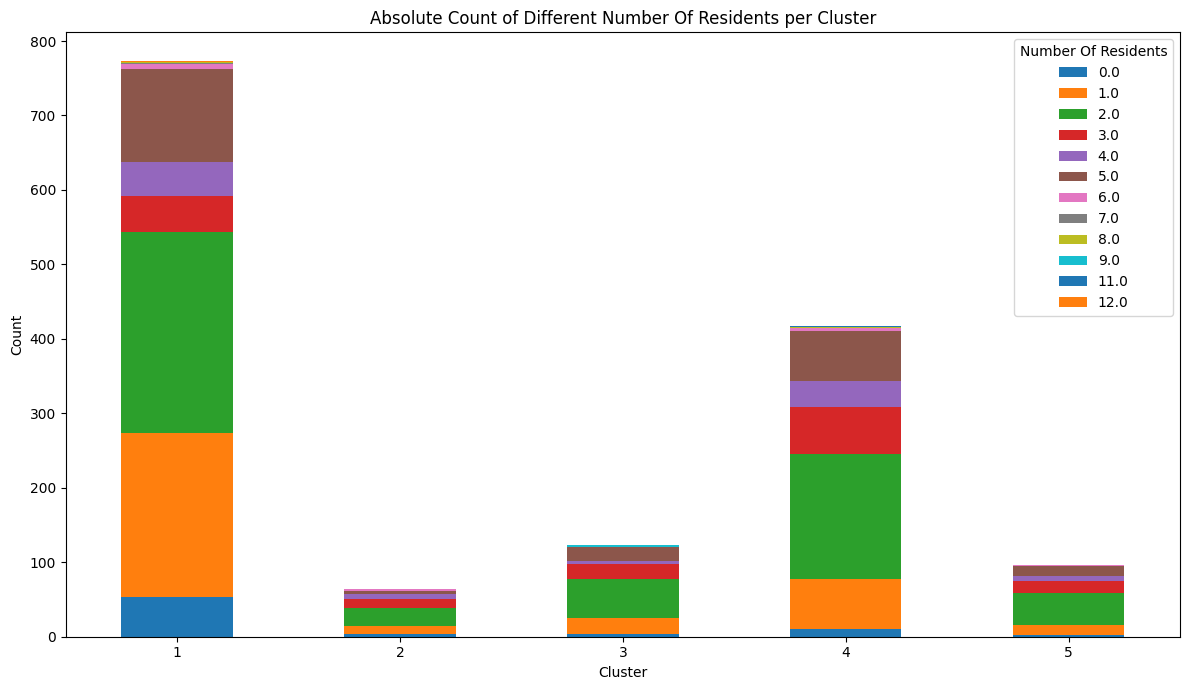

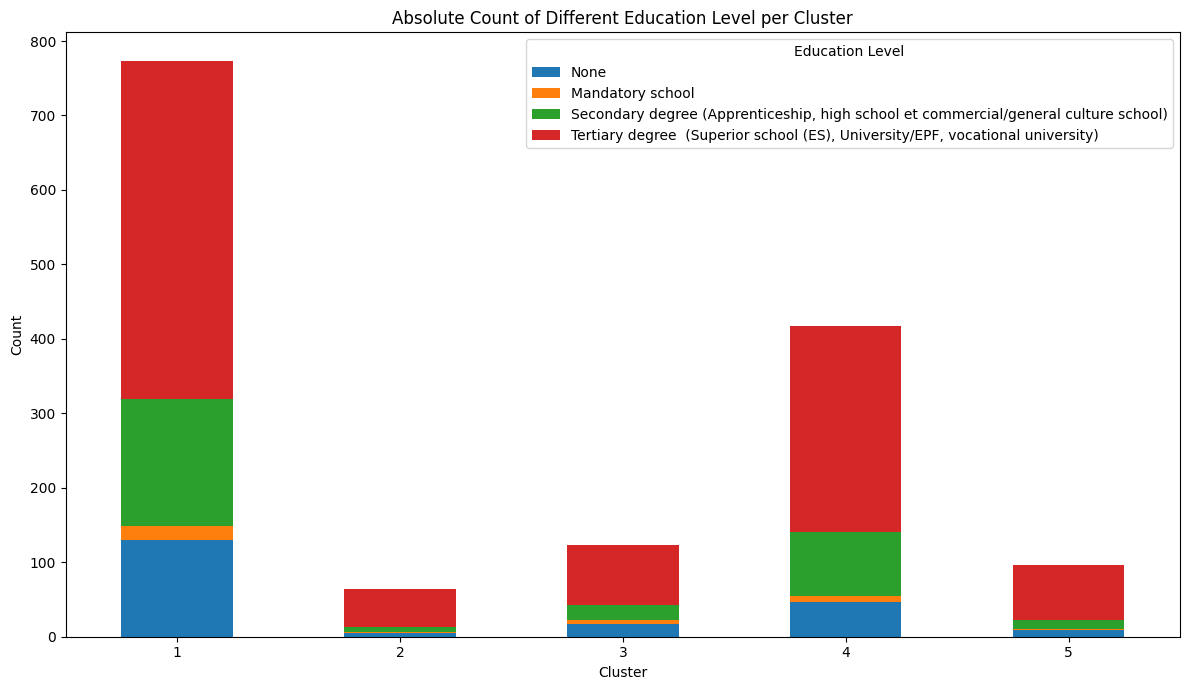

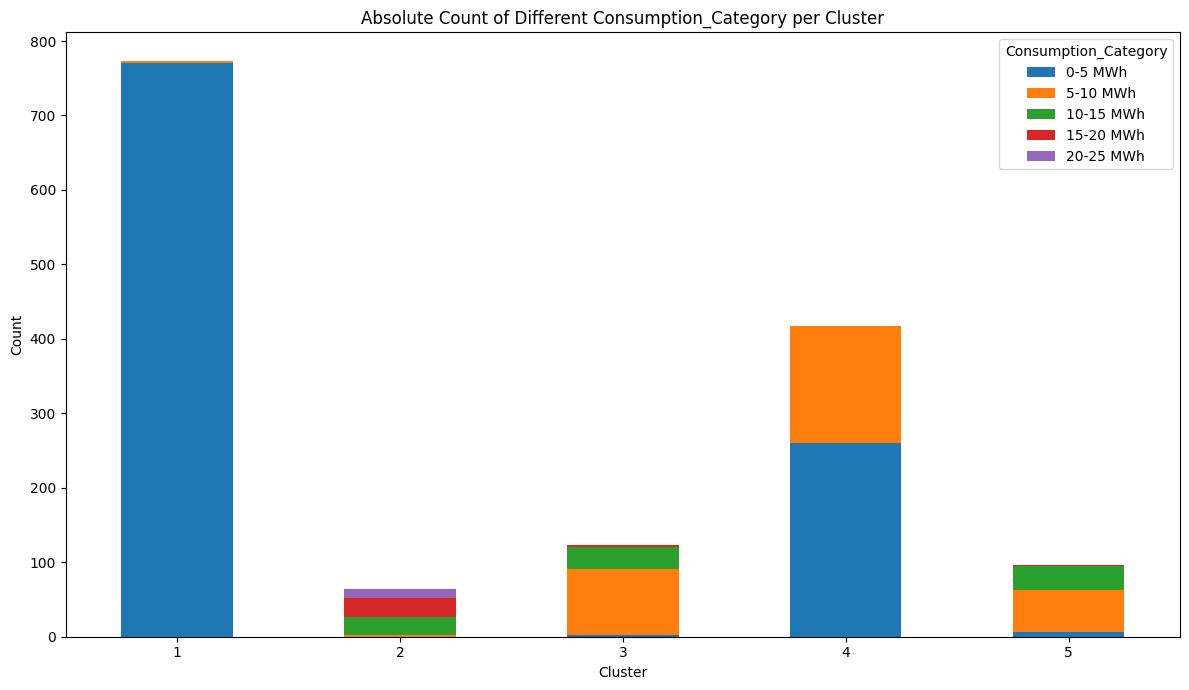

In [46]:

final_df_absolute = final_df.to_pandas()
clusters = sorted(final_df_absolute['cluster'].unique())

cols = final_df_absolute.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

custom_category_orders = {
    'tenant type': ['None', 'Living in a cooperative', 'Tenant', 'Owner'],
    'age': ['None', '18-35 years old', '36 - 50 years old', '51 - 65 years old', 'More than 65 years old'],
    'building type': ['None', 'Flat in a building with less than 5 flats', 'Flat in a building with 5 to 10 flats', 'Flat in a building with more than 10 flats','Terraced house','Semi-detached house','Detached house'],
    'solar panels': ['yes', 'no'],
    'heat pump': ['yes', 'no'],
    'electric vehicle': ['yes', 'no'],
    'electric water heating': ['yes', 'no'],
    'monthly income': ['None', 'I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ],
    'number of residents': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '11.0', '12.0'],
    'consumption_category': ['0-5 MWh', '5-10 MWh', '10-15 MWh', '15-20 MWh', '20-25 MWh'],
    'education level': ['None','Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)', 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)']
}

for col in category_columns:
    final_df_absolute[col] = final_df_absolute[col].astype(str)
    unique_cats = set(final_df_absolute[col].unique())

    fixed_category_order = custom_category_orders.get(col)
    if fixed_category_order is None:
        fixed_category_order = sorted(unique_cats)

    counts = {cat: [] for cat in fixed_category_order}

    for cl in clusters:
        cluster_subset = final_df_absolute[final_df_absolute['cluster'] == cl]
        for cat in fixed_category_order:
            count_cat = sum(cluster_subset[col] == cat)
            # Use count_cat directly for absolute values (not relative)
            counts[cat].append(count_cat)

    count_df = pd.DataFrame(counts, index=clusters)

    ax = count_df.plot(kind='bar', stacked=True, figsize=(12, 7))
    ax.set_title(f"Absolute Count of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=col.title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

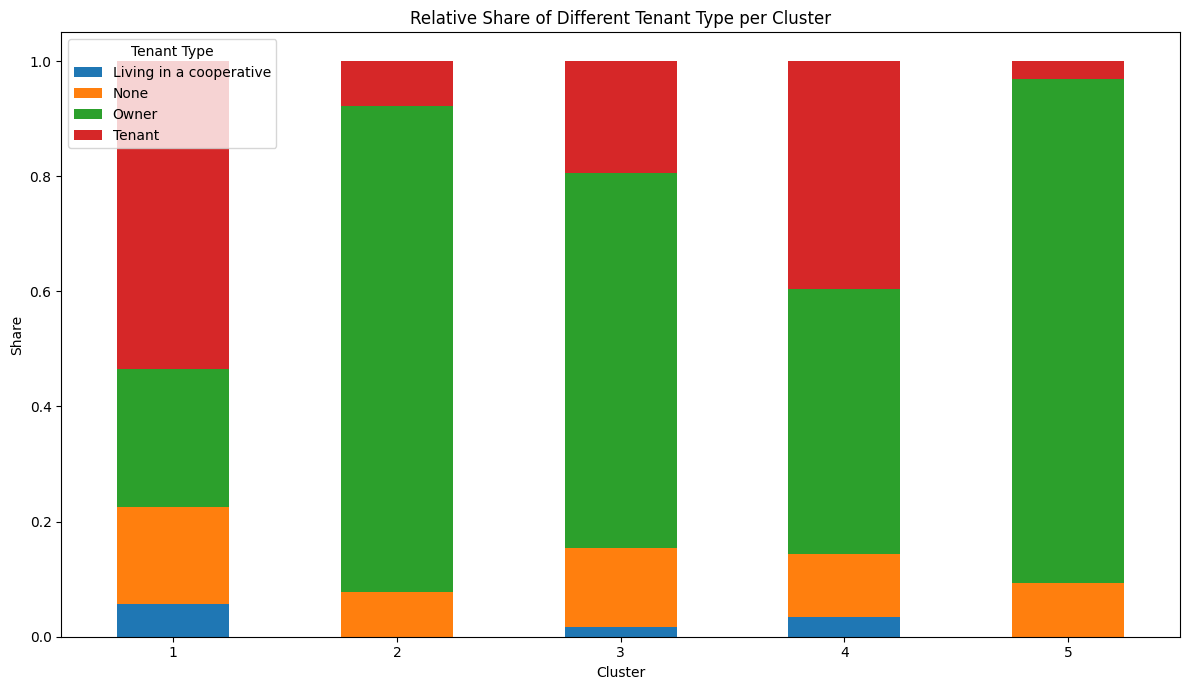

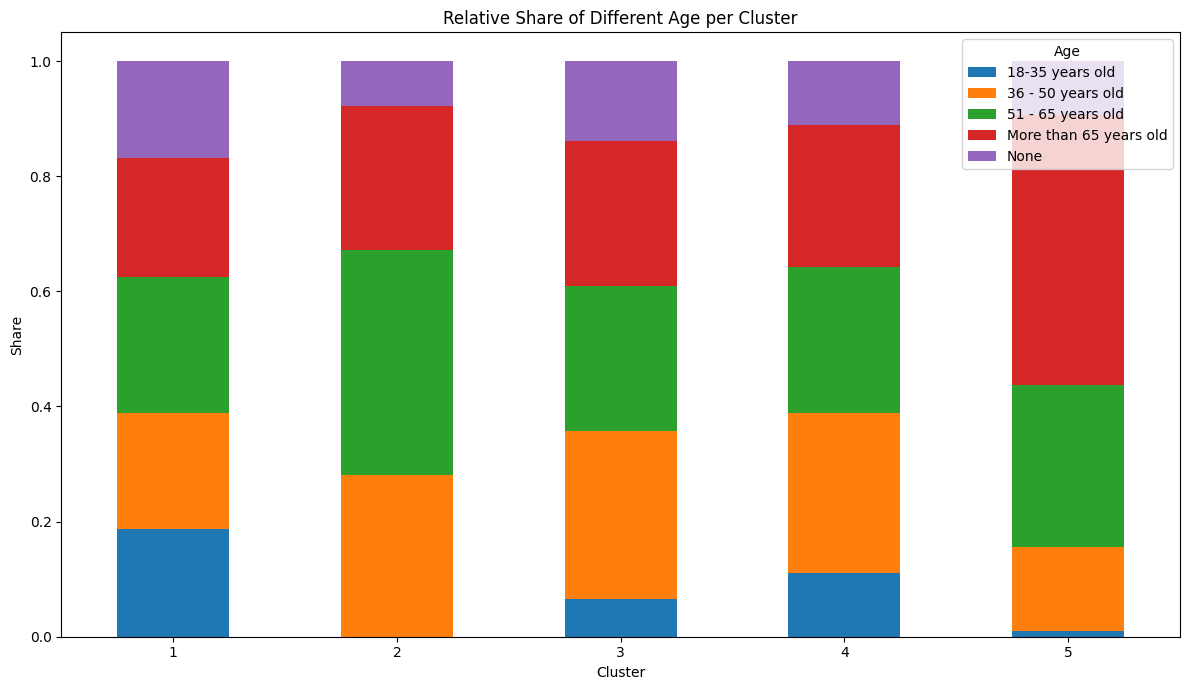

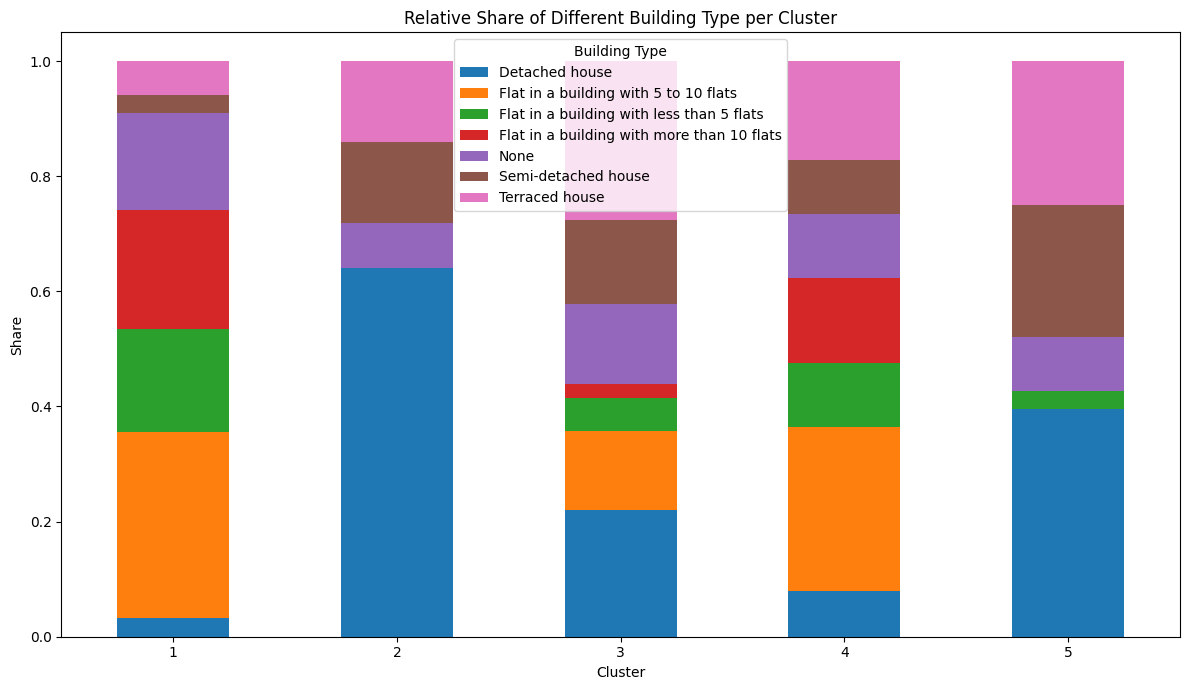

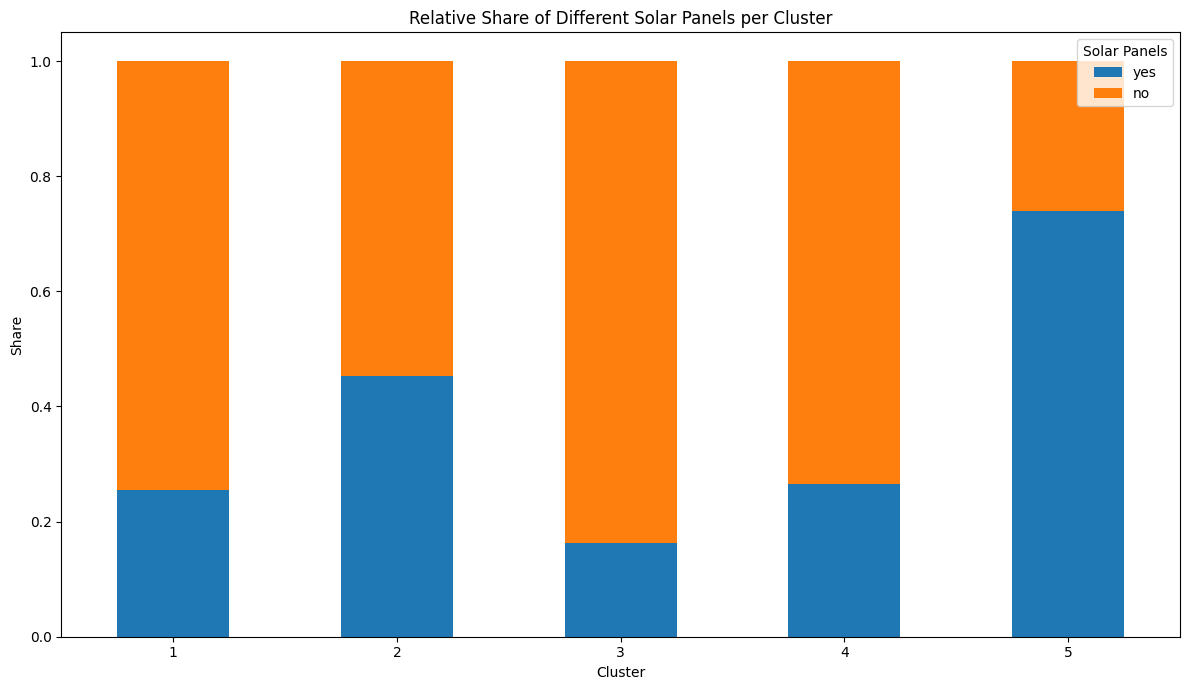

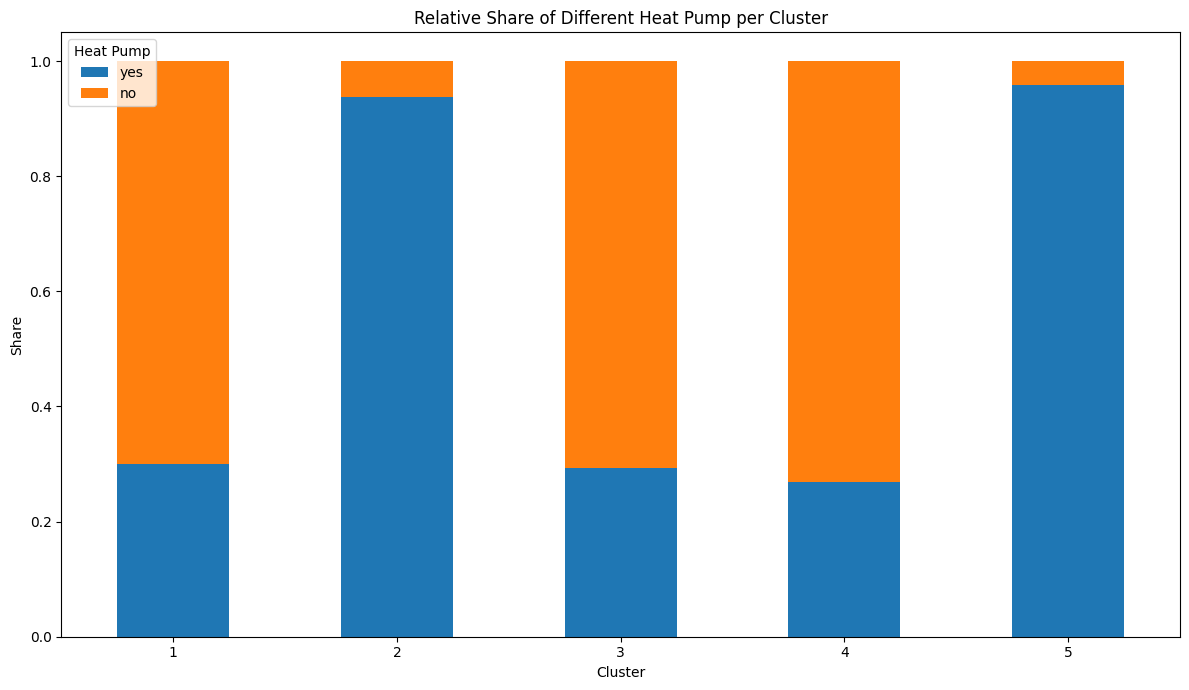

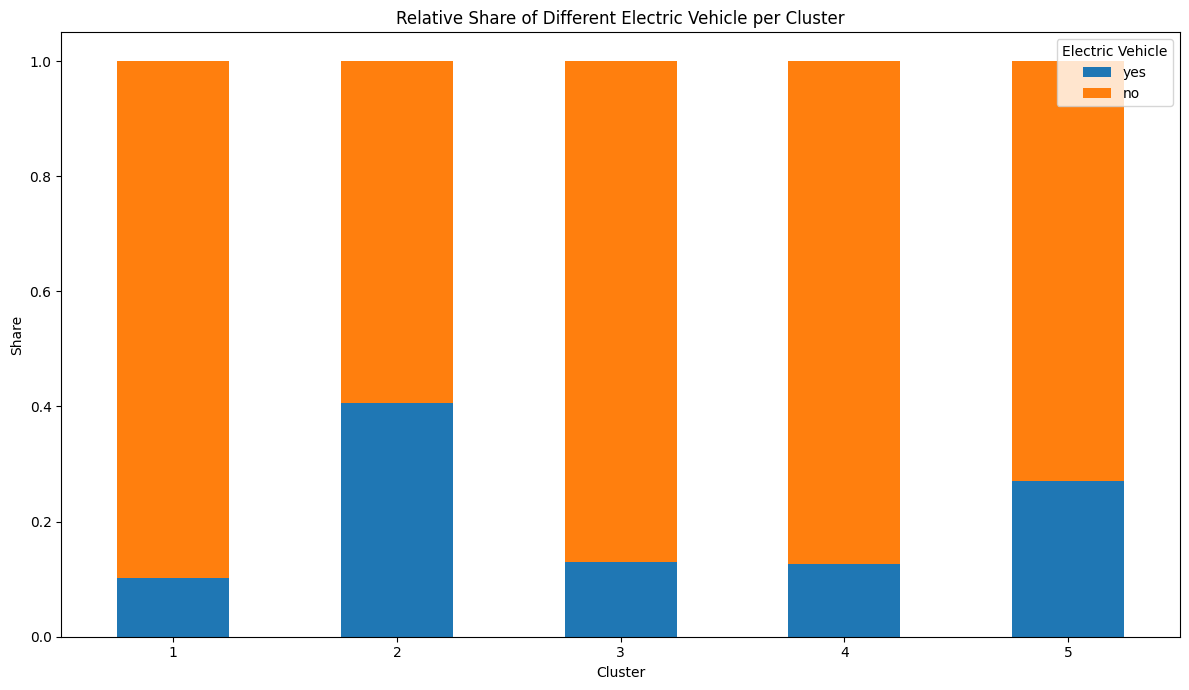

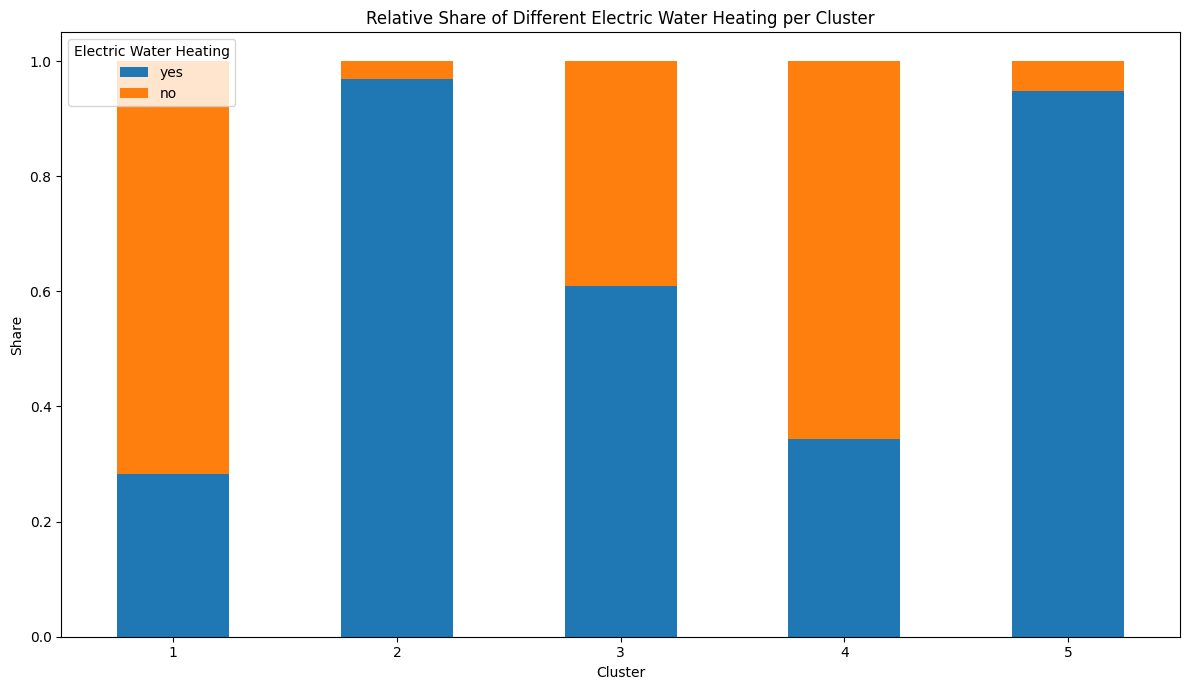

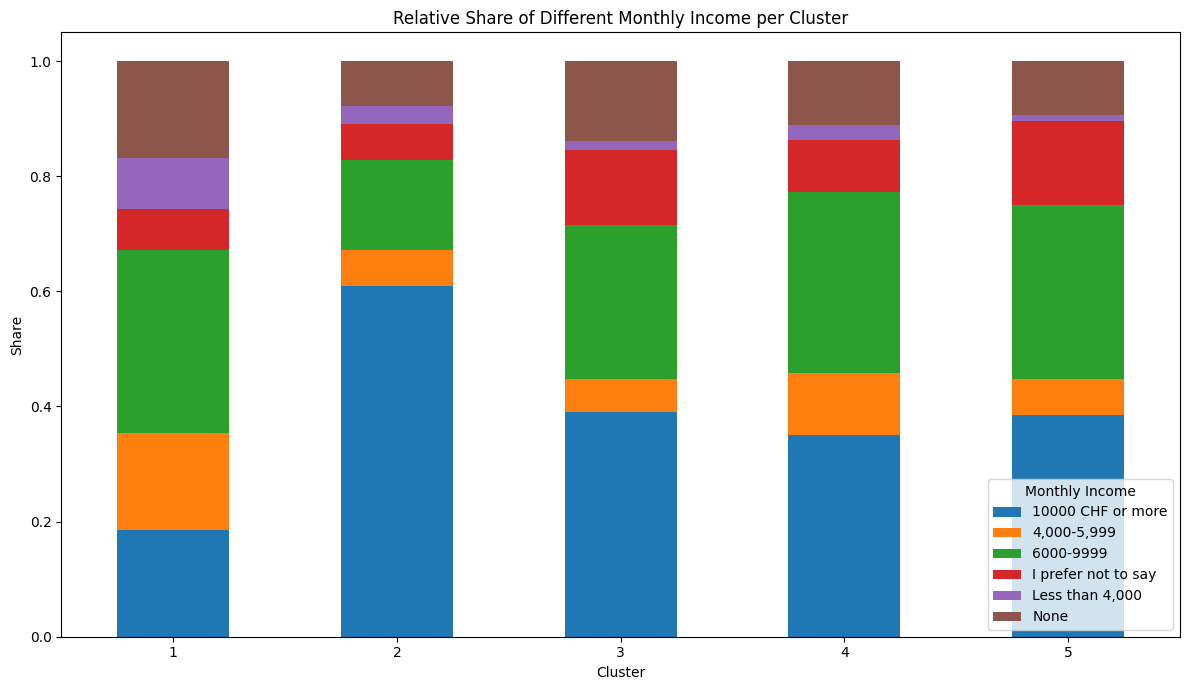

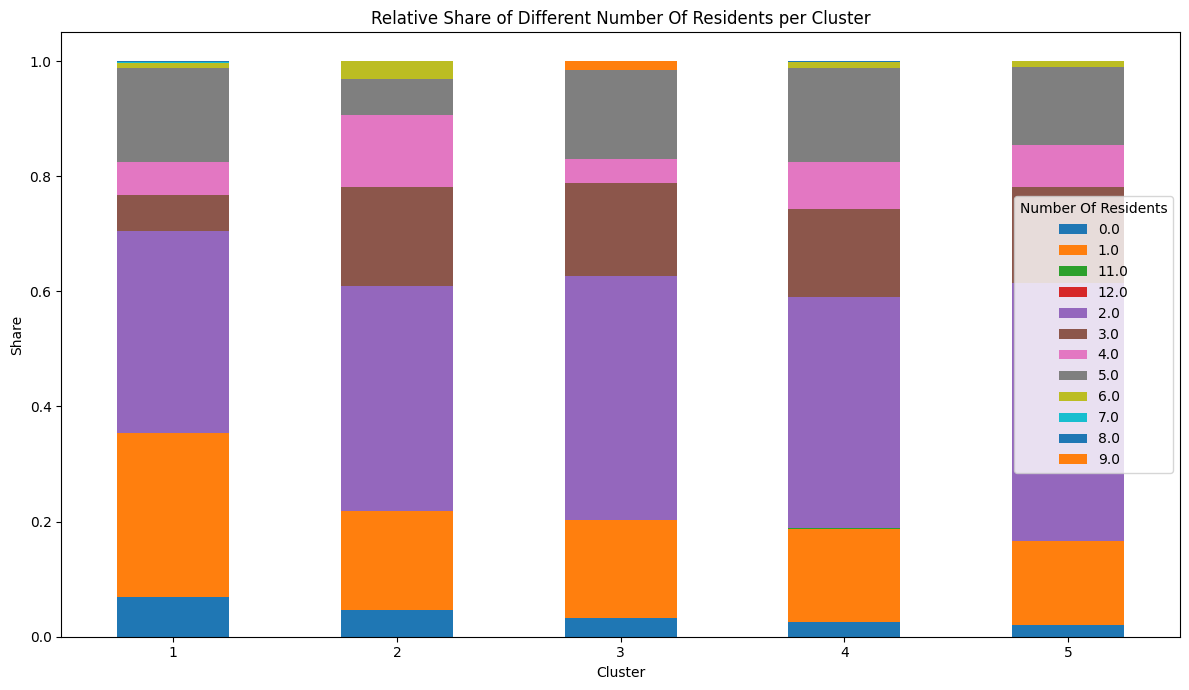

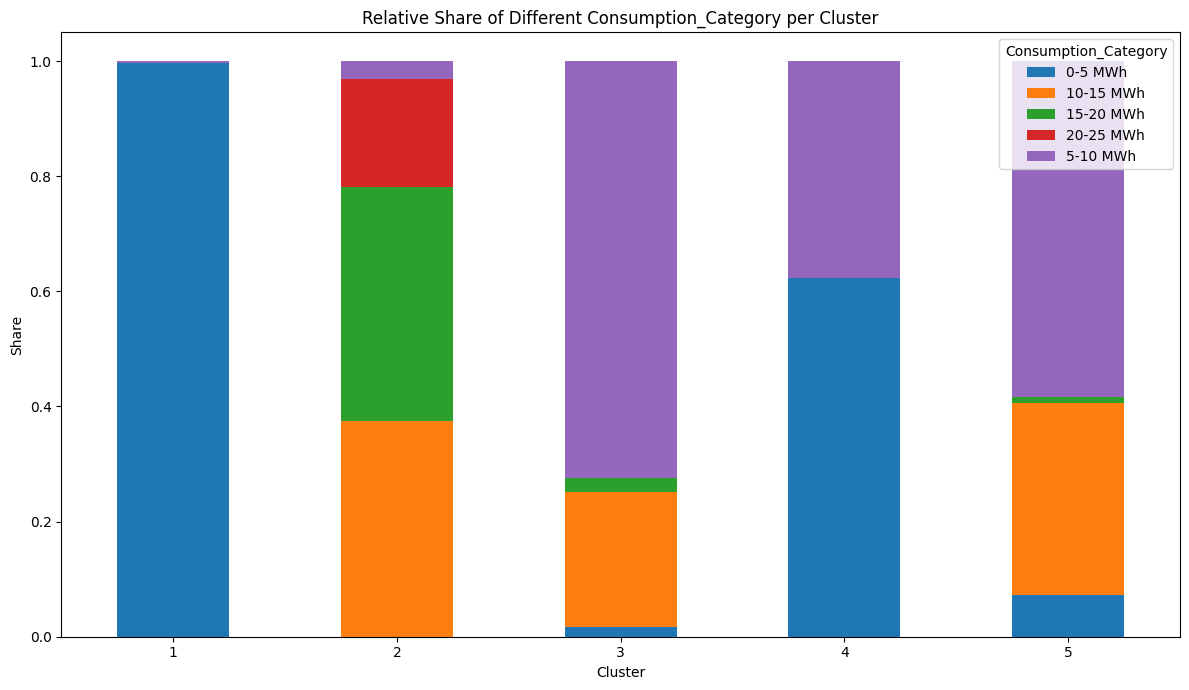

In [ ]:
final_df_relative = final_df.to_pandas()
clusters = sorted(final_df_relative['cluster'].unique())

cols = final_df_relative.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

custom_category_orders = {
    'tenant type': ['None', 'Living in a cooperative', 'Tenant', 'Owner'],
    'age': ['None', '18-35 years old', '36 - 50 years old', '51 - 65 years old','More than 65 years old'],
    'building type': ['None', 'Flat in a building with less than 5 flats', 'Flat in a building with 5 to 10 flats', 'Flat in a building with more than 10 flats','Terraced house','Semi-detached house','Detached house'],
    'solar panels': ['yes', 'no'],
    'heat pump': ['yes', 'no'],
    'electric vehicle': ['yes', 'no'],
    'electric water heating': ['yes', 'no'],
    'monthly income': ['None', 'I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ],
    'number of residents': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '11.0', '12.0'],
    'consumption_category': ['0-5 MWh', '5-10 MWh', '10-15 MWh', '15-20 MWh', '20-25 MWh'],
    'education level': ['None','Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)', 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)']
    # Add each column and its complete category order here
}

for col in category_columns:
    final_df_relative[col] = final_df_relative[col].astype(str)
    unique_cats = set(final_df_relative[col].unique())

    # Retrieve full fixed order for the column
    fixed_category_order = custom_category_orders.get(col)
    if fixed_category_order is None:
        # If no order provided, fall back to alphabetical (or raise error)
        fixed_category_order = sorted(unique_cats)

    # Optionally, check that fixed_category_order matches actual categories exactly
    #if set(fixed_category_order) != unique_cats:
        #raise ValueError(f"Category order for '{col}' does not match unique categories in data.")

    counts = {cat: [] for cat in fixed_category_order}

    for cl in clusters:
        cluster_subset = final_df_relative[final_df_relative['cluster'] == cl]
        total_in_cluster = len(cluster_subset)
        for cat in fixed_category_order:
            count_cat = sum(cluster_subset[col] == cat)
            prop_cat = count_cat / total_in_cluster if total_in_cluster > 0 else 0
            counts[cat].append(prop_cat)

    prop_df = pd.DataFrame(counts, index=clusters)

    ax = prop_df.plot(kind='bar', stacked=True, figsize=(12, 7))
    ax.set_title(f"Relative Share of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Share")
    ax.legend(title=col.title())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

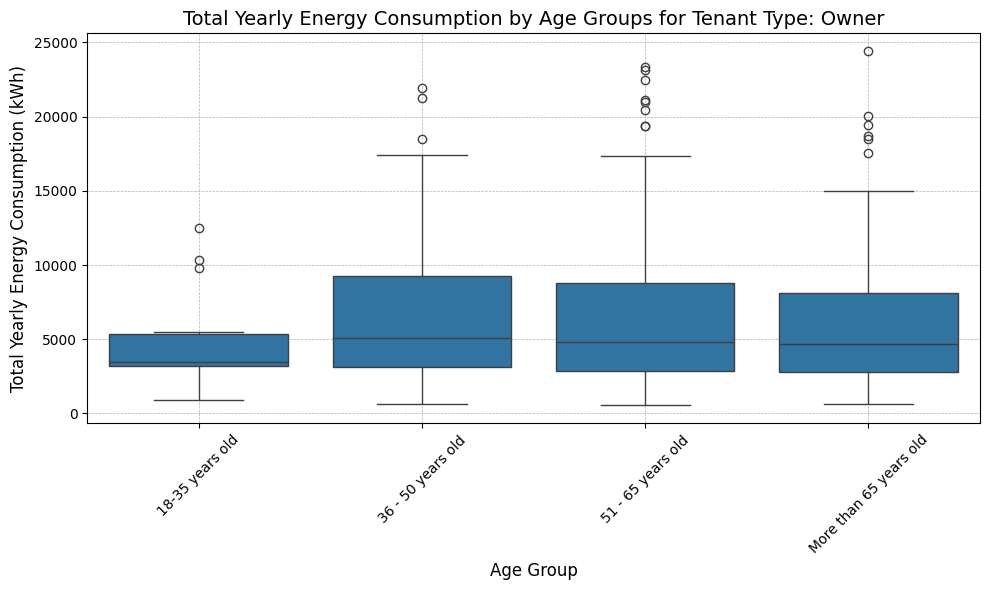

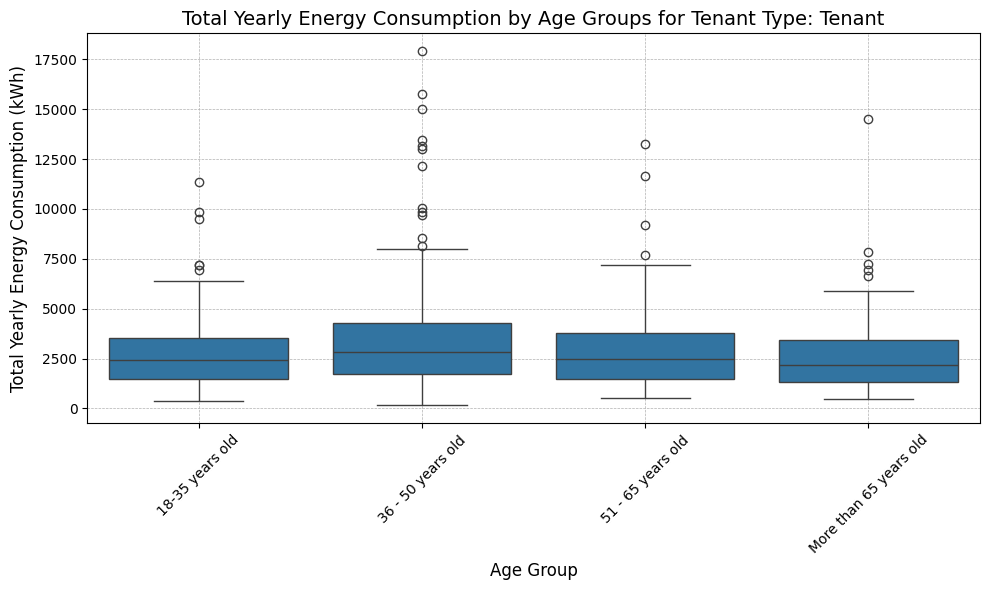

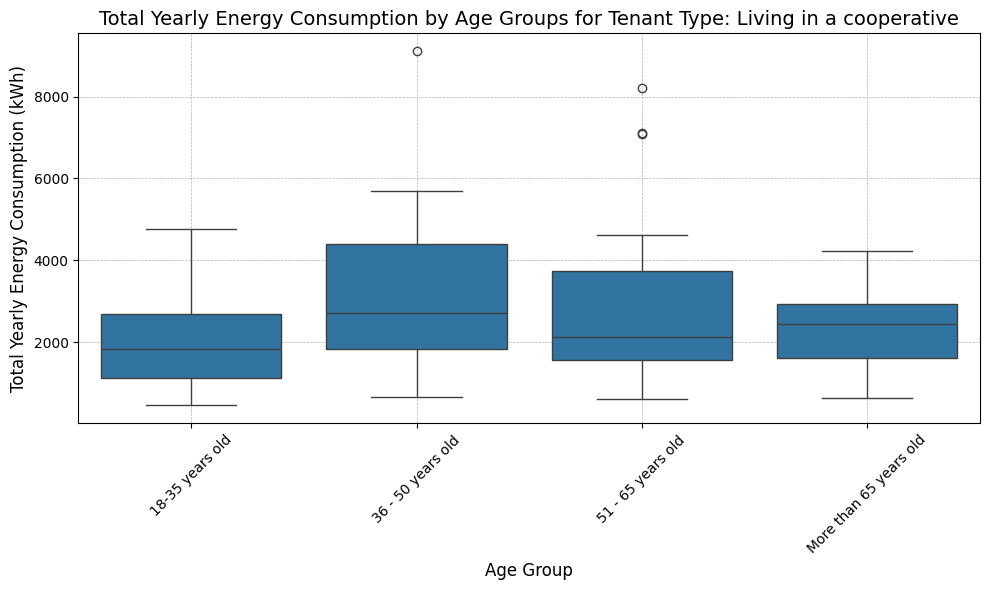

In [18]:
# Assuming final_df_absolut contains the relevant columns: 'tenant type', 'age', 'bruttolastgang_kwh_sum'

tenant_type_order = [
    'Owner',
    'Tenant',
    'Living in a cooperative'
]

age_order = [
    '18-35 years old',
    '36 - 50 years old',
    '51 - 65 years old',
    'More than 65 years old'
]

for tenant_type in tenant_type_order:
    plot_df = final_df_absolut[
        (final_df_absolut['tenant type'] == tenant_type) &
        (final_df_absolut['age'].isin(age_order))
    ]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=plot_df, x='age', y='bruttolastgang_kwh_sum', order=age_order)
    
    plt.title(f'Total Yearly Energy Consumption by Age Groups for Tenant Type: {tenant_type}', fontsize=14)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Total Yearly Energy Consumption (kWh)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()